In [19]:
#import required libraries
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from datetime import datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [7]:
# concatanating the date and the time stamp into one column

In [20]:
# import csv
# with open('concat.csv') as f:
#     reader = csv.reader(f)
#     with open('output.csv', 'w') as g:
#         writer = csv.writer(g)
#         for row in reader:
#             new_row = [' '.join([row[0], row[1]])] + row[2:]
#             writer.writerow(new_row)

In [21]:
# load data
def parse(x):
	return datetime.strptime(x, '%Y.%m.%d %H:%M')
dataset = read_csv('concat.csv', date_parser=parse)
#dataset = read_csv('output.csv')
#dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['Date time stamp', 'Bar OPEN Bid Quote', 'Bar HIGH Bid Quote', 'Bar LOW Bid Quote', 'Bar CLOSE Bid Quote', 'Volume']
dataset.index.name = 'Date time stamp'

# mark all NA values with 0
dataset['Bar OPEN Bid Quote'].fillna(0, inplace=True)
# drop the first 24 hours
#dataset = dataset[24:]

# summarize first 5 rows
print(dataset.head(5))
print(dataset.tail(5))

# save to file
dataset.to_csv('2016.csv')

                  Date time stamp  Bar OPEN Bid Quote  Bar HIGH Bid Quote  \
Date time stamp                                                             
0                2016.01.03 17:01             1.08712             1.08712   
1                2016.01.03 17:02             1.08708             1.08722   
2                2016.01.03 17:03             1.08717             1.08723   
3                2016.01.03 17:04             1.08718             1.08718   
4                2016.01.03 17:05             1.08703             1.08716   

                 Bar LOW Bid Quote  Bar CLOSE Bid Quote  Volume  
Date time stamp                                                  
0                          1.08712              1.08712       0  
1                          1.08708              1.08722       0  
2                          1.08717              1.08723       0  
3                          1.08711              1.08711       0  
4                          1.08701              1.08712       0 

In [9]:
#Loads the new “2016.csv” file and plots each series as a separate subplot

In [ ]:
# # load dataset
# dataset = read_csv('2016.csv', header=0, index_col=0)
# values = dataset.values

# # specify columns to plot
# groups = [0, 1, 2, 3, 4, 5]
# i = 1

# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

In [22]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('2016.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.000000   0.301724   0.300962   0.303582   0.302078        0.0  0.000001
2   0.000001   0.301495   0.301534   0.303353   0.302650        0.0  0.000003
3   0.000003   0.302010   0.301592   0.303868   0.302707        0.0  0.000004
4   0.000004   0.302067   0.301306   0.303525   0.302021        0.0  0.000005
5   0.000005   0.301208   0.301191   0.302953   0.302078        0.0  0.000007


In [ ]:
#LSTM with 50 neurons in the first hidden layer 
#1 neuron in the output layer for predicting foreign currency rate
#The input shape will be 1 time step with 6 features.

In [23]:
# split into train and test sets# 
values = reframed.values
n_train_minutes = 255 * 24 * 60 * 2
train = values[:n_train_minutes, :]
test = values[n_train_minutes:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(734400, 1, 6) (734400,) (9912, 1, 6) (9912,)


In [ ]:
#The model will be fit for 50 training epochs with a batch size of 72

Train on 734400 samples, validate on 9912 samples
Epoch 1/100
 - 8s - loss: 0.0072 - val_loss: 0.0056
Epoch 2/100
 - 7s - loss: 0.0084 - val_loss: 0.0024
Epoch 3/100
 - 8s - loss: 0.0074 - val_loss: 0.0067
Epoch 4/100
 - 7s - loss: 0.0058 - val_loss: 0.0061
Epoch 5/100
 - 7s - loss: 0.0046 - val_loss: 8.3327e-04
Epoch 6/100
 - 7s - loss: 0.0042 - val_loss: 0.0022
Epoch 7/100
 - 7s - loss: 0.0039 - val_loss: 0.0027
Epoch 8/100
 - 9s - loss: 0.0032 - val_loss: 0.0031
Epoch 9/100
 - 7s - loss: 0.0027 - val_loss: 0.0012
Epoch 10/100
 - 8s - loss: 0.0022 - val_loss: 0.0052
Epoch 11/100
 - 7s - loss: 0.0021 - val_loss: 0.0018
Epoch 12/100
 - 7s - loss: 0.0022 - val_loss: 0.0051
Epoch 13/100
 - 7s - loss: 0.0022 - val_loss: 0.0012
Epoch 14/100
 - 9s - loss: 0.0021 - val_loss: 0.0040
Epoch 15/100
 - 8s - loss: 0.0018 - val_loss: 0.0030
Epoch 16/100
 - 7s - loss: 0.0018 - val_loss: 0.0013
Epoch 17/100
 - 7s - loss: 0.0019 - val_loss: 0.0013
Epoch 18/100
 - 8s - loss: 0.0018 - val_loss: 0.0041
E

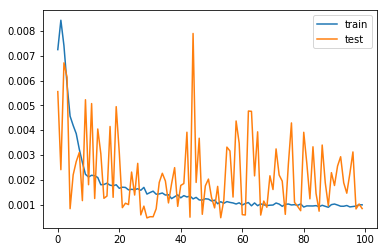

In [24]:
#design network# 
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(6, activation='relu'))
# model.add(Dense(6, activation='relu'))
# #output layer
# model.add(Dense(1, activation='linear'))
# # efficient gradient descent algorithm - adam
# model.compile(loss='mae', optimizer='adam')


model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(6))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')

# fit network
# batch size-number of instances that are evaluated before a weight update in the network is performed
history = model.fit(train_X, train_y, epochs=100, batch_size=200, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [25]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 854.960


In [ ]:
# # evaluate the model
# scores = model.evaluate(X, Y)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# new instance where we do not know the answer
#Xnew = array([[0.29466096, 0.30317302]])

In [ ]:
# make a prediction
#ynew = model.predict(Xnew)

In [ ]:
# show the inputs and predicted outputs
#print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))